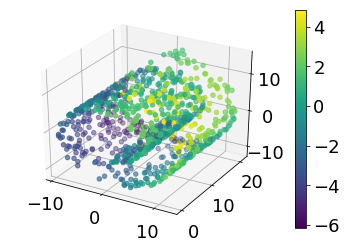

1/300 ... likelihood: -2815.4660085321048
2/300 ... likelihood: -2693.818686823337
3/300 ... likelihood: -2624.4485140242987
4/300 ... likelihood: -2581.920618987257
5/300 ... likelihood: -2541.879083234187
6/300 ... likelihood: -2488.1848996590343
7/300 ... likelihood: -2412.614488248408
8/300 ... likelihood: -2331.854499427727
9/300 ... likelihood: -2257.5134337738127
10/300 ... likelihood: -2189.409972178828
11/300 ... likelihood: -2125.2613482812894
12/300 ... likelihood: -2068.744493535466
13/300 ... likelihood: -2024.469663630353
14/300 ... likelihood: -1988.693300974161
15/300 ... likelihood: -1955.0666821666705
16/300 ... likelihood: -1921.4053763018137
17/300 ... likelihood: -1887.946750072127
18/300 ... likelihood: -1855.5511113908406
19/300 ... likelihood: -1825.1383192460708
20/300 ... likelihood: -1797.8427924558969
21/300 ... likelihood: -1773.7466103100173
22/300 ... likelihood: -1751.7048007261367
23/300 ... likelihood: -1731.9175679050945
24/300 ... likelihood: -1714.0

191/300 ... likelihood: -1445.9454581741704
192/300 ... likelihood: -1445.9246502304723
193/300 ... likelihood: -1445.9049759554796
194/300 ... likelihood: -1445.8863881932139
195/300 ... likelihood: -1445.8688370732914
196/300 ... likelihood: -1445.8522710205646
197/300 ... likelihood: -1445.8366377006446
198/300 ... likelihood: -1445.821884849092
199/300 ... likelihood: -1445.807960948888
200/300 ... likelihood: -1445.7948157751898
201/300 ... likelihood: -1445.782400841182
202/300 ... likelihood: -1445.7706696771713
203/300 ... likelihood: -1445.7595780513923
204/300 ... likelihood: -1445.749084078784
205/300 ... likelihood: -1445.7391482660537
206/300 ... likelihood: -1445.7297335303583
207/300 ... likelihood: -1445.7208051381867
208/300 ... likelihood: -1445.7123306484198
209/300 ... likelihood: -1445.704279817126
210/300 ... likelihood: -1445.6966244784317
211/300 ... likelihood: -1445.689338462956
212/300 ... likelihood: -1445.6823974486765
213/300 ... likelihood: -1445.67577887

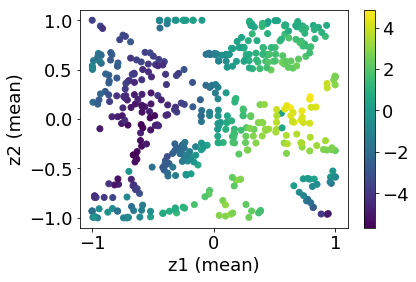

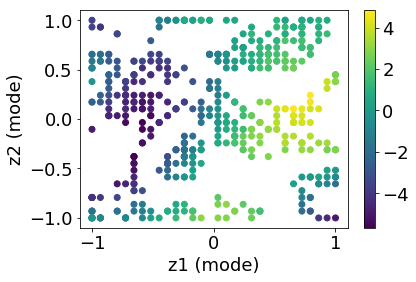

r2p: 0.9814660907071282
RMSEp: 0.3376815429244724
MAEp: 0.26905916139063407


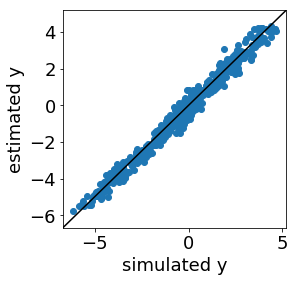

In [1]:
# -*- coding: utf-8 -*- 
# %reset -f
"""
@author: Hiromasa Kaneko
"""
%matplotlib inline
# Demonstration of GTMR (Generative Topographic Mapping Regression)

import matplotlib.figure as figure
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
from sklearn.datasets.samples_generator import make_swiss_roll
import mpl_toolkits.mplot3d

from gtm import gtm

# settings
shape_of_map = [30, 30]
shape_of_rbf_centers = [4, 4]
variance_of_rbfs = 0.5
lambda_in_em_algorithm = 0.001
number_of_iterations = 300
display_flag = 1
number_of_samples = 1000
noise_ratio_of_y = 0.1
random_state_number = 30000

# load a swiss roll dataset and make a y-variable
original_X, color = make_swiss_roll(number_of_samples, 0, random_state=10)
X = original_X
raw_y = 0.3 * original_X[:, 0] - 0.1 * original_X[:, 1] + 0.2 * original_X[:, 2]
original_y = raw_y + noise_ratio_of_y * raw_y.std(ddof=1) * np.random.randn(len(raw_y))

# plot
plt.rcParams["font.size"] = 18
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(original_X[:, 0], original_X[:, 1], original_X[:, 2], c=original_y)
fig.colorbar(p)
plt.show()

# divide a dataset into training data and test data
Xtrain = original_X[:500, :]
ytrain = original_y[:500]
Xtest = original_X[500:, :]
ytest = original_y[500:]

# autoscaling
# autoscaled_X = (original_X - original_X.mean(axis=0)) / original_X.std(axis=0,ddof=1)
autoscaled_Xtrain = (Xtrain - Xtrain.mean(axis=0)) / Xtrain.std(axis=0, ddof=1)
autoscaled_Xtest = (Xtest - X.mean(axis=0)) / X.std(axis=0, ddof=1)
autoscaled_ytrain = (ytrain - ytrain.mean()) / ytrain.std(ddof=1)

# construct GTMR model
input_dataset = np.c_[autoscaled_Xtrain, autoscaled_ytrain]
model = gtm(shape_of_map, shape_of_rbf_centers, variance_of_rbfs, lambda_in_em_algorithm, number_of_iterations,
            display_flag)
model.fit(input_dataset)
if model.success_flag:
    # calculate of responsibilities
    responsibilities = model.responsibility(input_dataset)

    # plot the mean of responsibilities
    means = responsibilities.dot(model.map_grids)
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(means[:, 0], means[:, 1], c=ytrain)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mean)")
    plt.ylabel("z2 (mean)")
    plt.show()

    # plot the mode of responsibilities
    modes = model.map_grids[responsibilities.argmax(axis=1), :]
    plt.figure()
    #    plt.figure(figsize=figure.figaspect(1))
    plt.scatter(modes[:, 0], modes[:, 1], c=ytrain)
    plt.colorbar()
    plt.ylim(-1.1, 1.1)
    plt.xlim(-1.1, 1.1)
    plt.xlabel("z1 (mode)")
    plt.ylabel("z2 (mode)")
    plt.show()

# GTMR prediction
predicted_ytest_mean, predicted_ytest_mode, responsibilities, px = model.gtmr_predict(autoscaled_Xtest)
predicted_ytest = predicted_ytest_mean * ytrain.std(ddof=1) + ytrain.mean()  # mean
# predicted_ytest = predicted_ytest_mode * ytrain.std(ddof=1) + ytrain.mean() # mode
predicted_ytest = np.ndarray.flatten(predicted_ytest)

# r2p, RMSEp, MAEp
print("r2p: {0}".format(float(1 - sum((ytest - predicted_ytest) ** 2) / sum((ytest - ytest.mean()) ** 2))))
print("RMSEp: {0}".format(float((sum((ytest - predicted_ytest) ** 2) / len(ytest)) ** (1 / 2))))
print("MAEp: {0}".format(float(sum(abs(ytest - predicted_ytest)) / len(ytest))))
# yy-plot
plt.figure(figsize=figure.figaspect(1))
plt.scatter(ytest, predicted_ytest)
YMax = np.max(np.array([np.array(ytest), predicted_ytest]))
YMin = np.min(np.array([np.array(ytest), predicted_ytest]))
plt.plot([YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)],
         [YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin)], 'k-')
plt.ylim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlim(YMin - 0.05 * (YMax - YMin), YMax + 0.05 * (YMax - YMin))
plt.xlabel("simulated y")
plt.ylabel("estimated y")
plt.show()
